# Assignment 2 - Geopandas

Create a map that visualizes the preferences of cities/municipalities between Jollibee and Mcdonalds in 'Metropolitan Manila'. Your map should distinctly show:
1. The locations of the Jollibee and Mcdonalds Establishments
1. The "preference" between the two
1. The bottom two cities in terms of number or restaurants/population

In [1]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-nkpg9ds7 because the default path (/home/jgacal/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
conn = psycopg2.connect(dbname="postgis", 
                 user="gsa2022", 
                 password="g5!V%T1Vmd", 
                 host="192.168.212.99", 
                 port=32771)

In [3]:
df_try = gpd.read_postgis("""
SELECT p.name, p.way, g.name_2, g.geom
FROM ph_point p
JOIN gadm.ph g ON st_within(p.way,g.geom)
WHERE g.name_1 = 'Metropolitan Manila'

""", conn, geom_col = 'way')
df_try.dropna(inplace=True)
df_try

name                         way      name_2  \
1              Martirez del '96  POINT (121.06568 14.53973)     Pateros   
2                            TK  POINT (121.06733 14.53969)     Pateros   
3                      Motolite  POINT (121.06740 14.54007)     Pateros   
4               1896 Revolution  POINT (121.06742 14.54012)     Pateros   
5      Southern Rizal Institute  POINT (121.06861 14.53961)     Pateros   
...                         ...                         ...         ...   
41103          Shanelly pisonet  POINT (121.01061 14.73347)  Valenzuela   
41107           Paraiso Village  POINT (121.01373 14.73587)  Valenzuela   
41108               Noah Street  POINT (121.01334 14.73666)  Valenzuela   
41109        Deparo High School  POINT (121.01191 14.73954)  Valenzuela   
41110            Celina Homes 2  POINT (121.01443 14.73682)  Valenzuela   

                                                    geom  
1      0106000020E610000001000000010300000001000000A3...  
2      0106000020E610000001000000010300000001000000A3...  
3      0106000020E610000001000000010300000001000000A3...  
4      0106000020E610000001000000010300000001000000A3...  
5      0106000020E610000001000000010300000001000000A3...  
...                                                  ...  
41103  0106000020E610000001000000010300000002000000DD...  
41107  0106000020E610000001000000010300000002000000DD...  
41108  0106000020E610000001000000010300000002000000DD...  
41109  0106000020E610000001000000010300000002000000DD...  
41110  0106000020E610000001000000010300000002000000DD...  

[25836 rows x 4 columns]

In [5]:
#Lets query our gadm map first and store it as our ph_shp
ph_shp = gpd.read_postgis('''
SELECT *
FROM gadm.ph
''', con = conn, geom_col = 'geom')
ph_shp
mm_shp = ph_shp[ph_shp['name_1']=='Metropolitan Manila']

## Locations of Each Mcdonald's Store and Jollibee Store in Metro Manila

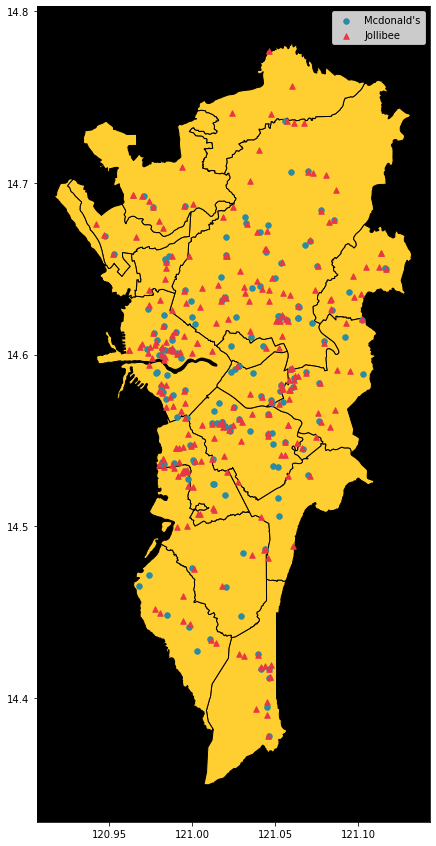

In [6]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_facecolor('black')
# df_mcdo = df_fastfood[(df_fastfood['name']=="Mcdonald's")]
# df_jollibee = df_fastfood[(df_fastfood['name']=='Jollibee')]

df_mcdo = gpd.GeoDataFrame(df_try[df_try.name.str.lower().str.contains('mcdo.*')], geometry='way')
df_jollibee = gpd.GeoDataFrame(df_try[df_try.name.str.lower().str.contains('jolli.*')], geometry='way')


mm_shp.plot(ax=ax, color='#FFCE30', edgecolor='black')

df_mcdo.plot(ax=ax, markersize=30, color='#288BA8', label="Mcdonald's")
df_jollibee.plot(marker='^', ax=ax, markersize=30, color='#E83845', label='Jollibee')
plt.legend()
plt.show()

## Preference for Jollibee and Mcdonald's Stores

In [7]:
jm_counts = [df_try[df_try.name.str.lower().str.contains('jolli.*')].groupby('name_2')['name'].count(),
 df_try[df_try.name.str.lower().str.contains('mcdo.*')].groupby('name_2')['name'].count()]

df_jm_density = pd.DataFrame(jm_counts, index=['jollibee', 'mcdo']).T
df_jm_density['j-m ratio'] = df_jm_density['jollibee'] / (df_jm_density['jollibee'] + df_jm_density['mcdo'])
# df_jm_density = df_jm_density.reset_index()
df_jm_density = pd.concat([df_jm_density, mm_shp.dissolve('name_2')['geom']], axis=1).drop(['Navotas'])
df_jm_density.rename(columns={0:'geom'}, inplace=True)
df_jm_density = gpd.GeoDataFrame(df_jm_density, geometry='geom')
df_jm_density

jollibee  mcdo  j-m ratio  \
name_2                                     
Kalookan City       9.0   3.0   0.750000   
Las Piñas           7.0   6.0   0.538462   
Makati City        25.0  21.0   0.543478   
Malabon             4.0   2.0   0.666667   
Mandaluyong         6.0   8.0   0.428571   
Manila             42.0  27.0   0.608696   
Marikina           11.0   4.0   0.733333   
Muntinlupa         13.0   6.0   0.684211   
Parañaque          15.0   7.0   0.681818   
Pasay City         22.0  10.0   0.687500   
Pasig City         20.0  10.0   0.666667   
Pateros             2.0   1.0   0.666667   
Quezon City        61.0  40.0   0.603960   
San Juan            2.0   2.0   0.500000   
Taguig              6.0   3.0   0.666667   
Valenzuela         10.0   3.0   0.769231   

                                                            geom  
name_2                                                            
Kalookan City  MULTIPOLYGON (((120.98495 14.63705, 120.98466 ...  
Las Piñas      MULTIPOLYGON (((120.99380 14.41080, 120.99392 ...  
Makati City    POLYGON ((121.06578 14.53872, 121.06594 14.538...  
Malabon        POLYGON ((120.95800 14.65938, 120.95796 14.658...  
Mandaluyong    POLYGON ((121.05405 14.57747, 121.05408 14.577...  
Manila         POLYGON ((120.99142 14.56218, 120.98849 14.561...  
Marikina       POLYGON ((121.07346 14.61962, 121.07432 14.620...  
Muntinlupa     POLYGON ((121.02339 14.35760, 121.02313 14.357...  
Parañaque      MULTIPOLYGON (((121.00110 14.45587, 121.00110 ...  
Pasay City     POLYGON ((121.00084 14.50921, 121.00070 14.509...  
Pasig City     POLYGON ((121.08282 14.54377, 121.08270 14.543...  
Pateros        POLYGON ((121.06864 14.53992, 121.06883 14.539...  
Quezon City    POLYGON ((121.01576 14.60610, 121.01511 14.605...  
San Juan       POLYGON ((121.02965 14.59402, 121.02961 14.594...  
Taguig         POLYGON ((121.05622 14.46785, 121.05588 14.467...  
Valenzuela     POLYGON ((120.94808 14.70633, 120.94830 14.706...

In [9]:
df_jm_density['coords'] = df_jm_density['geom'].apply(lambda x: x.representative_point().coords[:])
df_jm_density['coords'] = [coords[0] for coords in df_jm_density['coords']]
df_jm_density

jollibee  mcdo  j-m ratio  \
name_2                                     
Kalookan City       9.0   3.0   0.750000   
Las Piñas           7.0   6.0   0.538462   
Makati City        25.0  21.0   0.543478   
Malabon             4.0   2.0   0.666667   
Mandaluyong         6.0   8.0   0.428571   
Manila             42.0  27.0   0.608696   
Marikina           11.0   4.0   0.733333   
Muntinlupa         13.0   6.0   0.684211   
Parañaque          15.0   7.0   0.681818   
Pasay City         22.0  10.0   0.687500   
Pasig City         20.0  10.0   0.666667   
Pateros             2.0   1.0   0.666667   
Quezon City        61.0  40.0   0.603960   
San Juan            2.0   2.0   0.500000   
Taguig              6.0   3.0   0.666667   
Valenzuela         10.0   3.0   0.769231   

                                                            geom  \
name_2                                                             
Kalookan City  MULTIPOLYGON (((120.98495 14.63705, 120.98466 ...   
Las Piñas      MULTIPOLYGON (((120.99380 14.41080, 120.99392 ...   
Makati City    POLYGON ((121.06578 14.53872, 121.06594 14.538...   
Malabon        POLYGON ((120.95800 14.65938, 120.95796 14.658...   
Mandaluyong    POLYGON ((121.05405 14.57747, 121.05408 14.577...   
Manila         POLYGON ((120.99142 14.56218, 120.98849 14.561...   
Marikina       POLYGON ((121.07346 14.61962, 121.07432 14.620...   
Muntinlupa     POLYGON ((121.02339 14.35760, 121.02313 14.357...   
Parañaque      MULTIPOLYGON (((121.00110 14.45587, 121.00110 ...   
Pasay City     POLYGON ((121.00084 14.50921, 121.00070 14.509...   
Pasig City     POLYGON ((121.08282 14.54377, 121.08270 14.543...   
Pateros        POLYGON ((121.06864 14.53992, 121.06883 14.539...   
Quezon City    POLYGON ((121.01576 14.60610, 121.01511 14.605...   
San Juan       POLYGON ((121.02965 14.59402, 121.02961 14.594...   
Taguig         POLYGON ((121.05622 14.46785, 121.05588 14.467...   
Valenzuela     POLYGON ((120.94808 14.70633, 120.94830 14.706...   

                                                 coords  
name_2                                                   
Kalookan City        (121.04615732805766, 14.743260385)  
Las Piñas             (121.00125255161754, 14.43518543)  
Makati City          (121.03603962590697, 14.547920705)  
Malabon               (120.95678936284554, 14.67388058)  
Mandaluyong    (121.03753064862448, 14.585350510000001)  
Manila                (120.98355502586293, 14.59954214)  
Marikina       (121.10702067839902, 14.646957395000001)  
Muntinlupa           (121.03220290537041, 14.410797595)  
Parañaque             (121.01697562501957, 14.48537064)  
Pasay City           (121.00727950081219, 14.532540325)  
Pasig City            (121.08290321110482, 14.58267546)  
Pateros        (121.07091340319127, 14.546780590000001)  
Quezon City           (121.0564453485471, 14.674670695)  
San Juan       (121.03672068872078, 14.602780339999999)  
Taguig          (121.0509837159506, 14.507995605000001)  
Valenzuela           (120.98422731411084, 14.705635545)

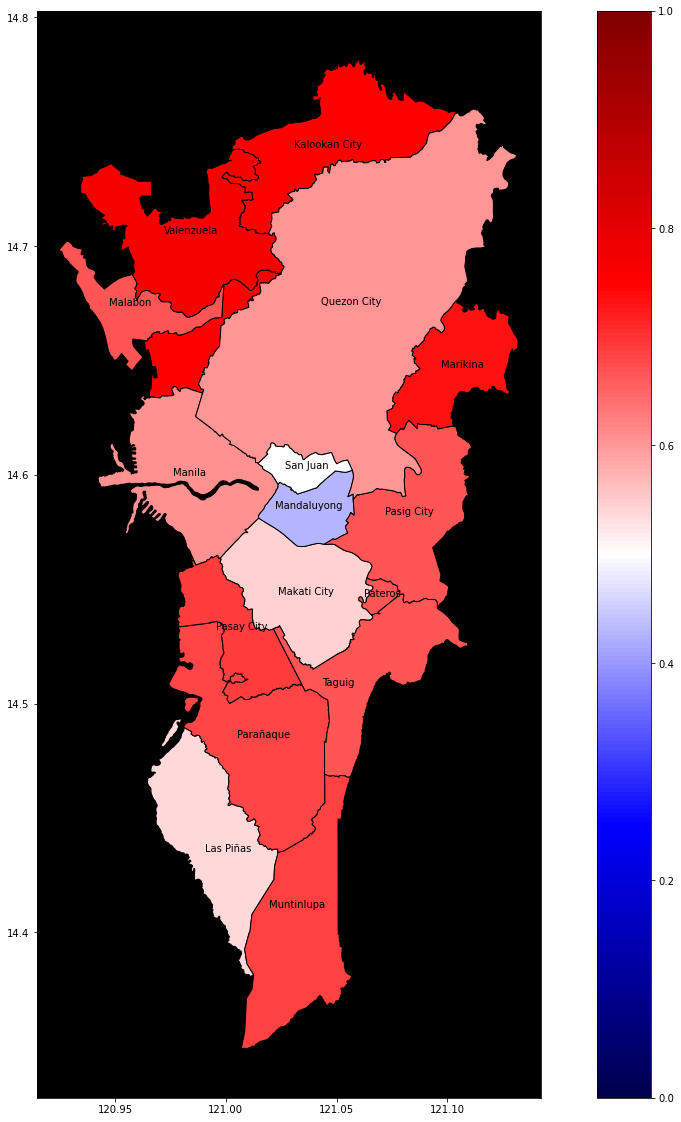

In [23]:
fig = plt.figure(figsize=(20,20))
ax = plt.axes()
ax.set_facecolor('black')
df_jm_density.plot(column='j-m ratio', cmap='seismic', legend=True, vmin=0, vmax=1, ax=ax, linewidth=1, edgecolor='black')

for idx, row in df_jm_density.iterrows():
    plt.annotate(text=idx, xy=row['coords'],
                 horizontalalignment='center')

plt.show()

In [24]:
df_jm_density['jollibee'].sum()

255.0

In [25]:
df_jm_density['mcdo'].sum()

153.0

There are a total of 255 Jollibee stores and 153 Mcdonald's stores in the metro. The heat map above shows the proportion of jollibees there are to mcdonald's stores in each city. The more red a city is, the more jollibees there are in the area, while the bluer the city is, the more mcdonald's stores there are in the area. It is clearly seen in the plot that almost all cities in the metro have more jollibees than mcdonald's stores. However, Mandaluyong and San Juan city had more or equal number of Mcdonald's stores than jollibee stores.

For Mcdonald's there is a lot of opportunity for market penetration especially given that Metro Manila is the most densly populated area in the country. Meanwhile, Jollibee should continue its dominance on the market but remain vigilant with the possibility that Mcdonald's may try to expand in Jollibee-dominated areas. 

## The bottom two cities in terms of number or restaurants/population

In [27]:
fin_pop = pd.read_csv('financial_pop.csv')
mm_data = mm_shp.merge(fin_pop, left_on = ['name_1','name_2'],
                       right_on = ['shp_province','shp_municipality'])
mm_data

gid gid_0       name_0     gid_1               name_1 nl_name_1  \
0   973   PHL  Philippines  PHL.47_1  Metropolitan Manila      None   
1   974   PHL  Philippines  PHL.47_1  Metropolitan Manila      None   
2   965   PHL  Philippines  PHL.47_1  Metropolitan Manila      None   
3   966   PHL  Philippines  PHL.47_1  Metropolitan Manila      None   
4   967   PHL  Philippines  PHL.47_1  Metropolitan Manila      None   
5   968   PHL  Philippines  PHL.47_1  Metropolitan Manila      None   
6   961   PHL  Philippines  PHL.47_1  Metropolitan Manila      None   
7   962   PHL  Philippines  PHL.47_1  Metropolitan Manila      None   
8   963   PHL  Philippines  PHL.47_1  Metropolitan Manila      None   
9   964   PHL  Philippines  PHL.47_1  Metropolitan Manila      None   
10  969   PHL  Philippines  PHL.47_1  Metropolitan Manila      None   
11  970   PHL  Philippines  PHL.47_1  Metropolitan Manila      None   
12  971   PHL  Philippines  PHL.47_1  Metropolitan Manila      None   
13  972   PHL  Philippines  PHL.47_1  Metropolitan Manila      None   
14  975   PHL  Philippines  PHL.47_1  Metropolitan Manila      None   
15  976   PHL  Philippines  PHL.47_1  Metropolitan Manila      None   
16  977   PHL  Philippines  PHL.47_1  Metropolitan Manila      None   

          gid_2         name_2                       varname_2 nl_name_2  ...  \
0   PHL.47.13_1        Pateros                            None      None  ...   
1   PHL.47.14_1    Quezon City                            None      None  ...   
2    PHL.47.5_1    Mandaluyong            Mandaluyong, City of      None  ...   
3    PHL.47.6_1         Manila  City of Manila|Manila, City of      None  ...   
4    PHL.47.7_1       Marikina               Marikina, City of      None  ...   
5    PHL.47.8_1     Muntinlupa             Muntinlupa, City of      None  ...   
6    PHL.47.1_1  Kalookan City                            None      None  ...   
7    PHL.47.2_1      Las Piñas              Las Piñas, City of      None  ...   
8    PHL.47.3_1    Makati City                 Makati, City of      None  ...   
9    PHL.47.4_1        Malabon                            None      None  ...   
10   PHL.47.9_1        Navotas                            None      None  ...   
11  PHL.47.10_1      Parañaque              Parañaque, City of      None  ...   
12  PHL.47.11_1     Pasay City                            None      None  ...   
13  PHL.47.12_1     Pasig City                  Pasig, City of      None  ...   
14  PHL.47.15_1       San Juan                            None      None  ...   
15  PHL.47.16_1         Taguig                            None      None  ...   
16  PHL.47.17_1     Valenzuela             Valenzuela, City of      None  ...   

   tot_tax_revenue tot_current_oper_income total_oper_expenses  \
0        56.080847              201.599229          163.300161   
1     12833.213830            18526.608000         9782.849320   
2      4851.641755             5862.396531         2960.364965   
3      8009.830859            11975.244480         7523.296121   
4      1008.797613             2366.331933         1606.966038   
5      2546.918961             4315.507771         2990.154537   
6      2078.233727             4718.102455         2885.275622   
7       948.154753             2107.391432         1743.842711   
8     11338.122110            13575.480700         7444.964790   
9       406.027365             1254.476844          945.121196   
10      407.431602             1097.724581          525.924780   
11     2635.568281             4137.782345         2914.364076   
12     3086.063885             4175.372312         3224.397454   
13     6305.083293             9003.319553         3651.933294   
14     1033.922748             1548.555877         1250.288409   
15     3693.742053             6559.588487         4226.739028   
16     2326.883631             3600.962103         2900.140827   

   net_oper_income total_non_income_receipts  capital_expenditure  \
0       

In [32]:
mm_rest = gpd.read_postgis('''
SELECT p.name, p.way
FROM ph_point AS p
JOIN gadm.ph as g ON st_within(p.way, g.geom)
WHERE p.amenity = 'restaurant' AND g.name_1 = 'Metropolitan Manila'
'''
, con = conn, geom_col = 'way'
)
mm_rest

name                         way
0           Jing ragas tapsi  POINT (121.06719 14.54281)
1     Aling Tessie's Lugawan  POINT (121.06617 14.54531)
2               Dos Hermanas  POINT (121.06697 14.54478)
3                RnR Burgers  POINT (121.06811 14.54563)
4                        ACC  POINT (121.06819 14.54561)
...                      ...                         ...
2872      Lugawan ni Uring's  POINT (121.02190 14.69425)
2873              Food to go  POINT (120.99004 14.70633)
2874     V-Migz - Meycauayan  POINT (120.95946 14.72231)
2875  EatMoto Mini Banchetto  POINT (120.95361 14.73069)
2876                 D Plaza  POINT (120.96295 14.72684)

[2877 rows x 2 columns]

In [38]:
mm_other_rest = gpd.read_postgis(f'''
SELECT p.name, p.way
FROM ph_point AS p
JOIN gadm.ph as g ON st_within(p.way, g.geom)
WHERE p.name 
IN (
    SELECT p2.name
    FROM ph_point AS p2
    JOIN gadm.ph as g2 ON st_within(p2.way, g2.geom)
    WHERE p2.amenity = 'restaurant' AND g2.name_1 = 'Metropolitan Manila'
) 

AND g.name_1 = 'Metropolitan Manila'
'''
, con = conn, geom_col = 'way'
)
mm_other_rest

name                         way
0     Ikay's Seafood Sutukil  POINT (121.10277 14.64125)
1            Wai Ying Dimsum  POINT (120.99326 14.56609)
2              Single Origin  POINT (121.02145 14.55200)
3              Single Origin  POINT (121.04933 14.55157)
4             Partners Pares  POINT (121.01821 14.63394)
...                      ...                         ...
3775        Dulcelin Gourmet  POINT (121.07486 14.64937)
3776         Bastille Bistro  POINT (121.03604 14.45722)
3777                Silantro  POINT (121.07480 14.64927)
3778                Silantro  POINT (121.02847 14.42476)
3779                Silantro  POINT (121.05789 14.56773)

[3780 rows x 2 columns]

In [43]:
dict_ = {}
for idx, data in mm_other_rest.iterrows():
    for idx2, data2 in mm_shp[['name_2', 'geom']].iterrows():
        
        if data['way'].within(data2['geom']):
            dict_[idx] = data2['name_2']

In [52]:
mm_rest_final = pd.concat([mm_other_rest, pd.DataFrame(dict_, index=['location']).T], axis=1)
mm_rest_final

name                         way     location
0     Ikay's Seafood Sutukil  POINT (121.10277 14.64125)     Marikina
1            Wai Ying Dimsum  POINT (120.99326 14.56609)       Manila
2              Single Origin  POINT (121.02145 14.55200)  Makati City
3              Single Origin  POINT (121.04933 14.55157)  Makati City
4             Partners Pares  POINT (121.01821 14.63394)  Quezon City
...                      ...                         ...          ...
3775        Dulcelin Gourmet  POINT (121.07486 14.64937)  Quezon City
3776         Bastille Bistro  POINT (121.03604 14.45722)    Parañaque
3777                Silantro  POINT (121.07480 14.64927)  Quezon City
3778                Silantro  POINT (121.02847 14.42476)   Muntinlupa
3779                Silantro  POINT (121.05789 14.56773)   Pasig City

[3780 rows x 3 columns]

In [53]:
mm_rest_final.groupby('location')['name'].count()

location
Kalookan City     37
Las Piñas        142
Makati City      816
Malabon           22
Mandaluyong      119
Manila           390
Marikina         139
Muntinlupa       216
Navotas            1
Parañaque        222
Pasay City       216
Pasig City       260
Pateros           15
Quezon City      959
San Juan         137
Taguig            29
Valenzuela        60
Name: name, dtype: int64

In [87]:
mm_rest_density = pd.concat([mm_rest_final.groupby('location')['name'].count(), mm_data[['name_2', 'pop']].set_index('name_2')], axis=1)
mm_rest_density['density'] = mm_rest_density['name']/mm_rest_density['pop']
mm_rest_density['log_density'] = mm_rest_density['density'].apply(np.log)
mm_rest_density['scaled_density'] = (mm_rest_density['log_density'] - mm_rest_density['log_density'].min()) / (mm_rest_density['log_density'].max() - mm_rest_density['log_density'].min())

mm_rest_density

name        pop   density  log_density  scaled_density
Kalookan City    37  1583978.0  0.000023   -10.664532        0.300968
Las Piñas       142   588894.0  0.000241    -8.330174        0.699579
Makati City     816   582602.0  0.001401    -6.570845        1.000000
Malabon          22   365525.0  0.000060    -9.718048        0.462588
Mandaluyong     119   386276.0  0.000308    -8.085184        0.741414
Manila          390  1780148.0  0.000219    -8.426060        0.683206
Marikina        139   450741.0  0.000308    -8.084174        0.741586
Muntinlupa      216   504509.0  0.000428    -7.756063        0.797614
Navotas           1   249463.0  0.000004   -12.427066        0.000000
Parañaque       222   665822.0  0.000333    -8.006100        0.754918
Pasay City      216   416522.0  0.000519    -7.564416        0.830339
Pasig City      260   755300.0  0.000344    -7.974189        0.760367
Pateros          15    63840.0  0.000235    -8.356085        0.695155
Quezon City     959  2936116.0  0.000327    -8.026707        0.751399
San Juan        137   122180.0  0.001121    -6.793270        0.962019
Taguig           29   804915.0  0.000036   -10.231196        0.374964
Valenzuela       60   620422.0  0.000097    -9.243811        0.543568

In [88]:
df_final = gpd.GeoDataFrame(pd.concat([mm_rest_density, mm_shp[['name_2', 'geom']].set_index('name_2')], axis=1), geometry='geom')

df_final['coords'] = df_final['geom'].apply(lambda x: x.representative_point().coords[:])
df_final['coords'] = [coords[0] for coords in df_final['coords']]
df_final
df_final

name        pop   density  log_density  scaled_density  \
Kalookan City    37  1583978.0  0.000023   -10.664532        0.300968   
Las Piñas       142   588894.0  0.000241    -8.330174        0.699579   
Makati City     816   582602.0  0.001401    -6.570845        1.000000   
Malabon          22   365525.0  0.000060    -9.718048        0.462588   
Mandaluyong     119   386276.0  0.000308    -8.085184        0.741414   
Manila          390  1780148.0  0.000219    -8.426060        0.683206   
Marikina        139   450741.0  0.000308    -8.084174        0.741586   
Muntinlupa      216   504509.0  0.000428    -7.756063        0.797614   
Navotas           1   249463.0  0.000004   -12.427066        0.000000   
Parañaque       222   665822.0  0.000333    -8.006100        0.754918   
Pasay City      216   416522.0  0.000519    -7.564416        0.830339   
Pasig City      260   755300.0  0.000344    -7.974189        0.760367   
Pateros          15    63840.0  0.000235    -8.356085        0.695155   
Quezon City     959  2936116.0  0.000327    -8.026707        0.751399   
San Juan        137   122180.0  0.001121    -6.793270        0.962019   
Taguig           29   804915.0  0.000036   -10.231196        0.374964   
Valenzuela       60   620422.0  0.000097    -9.243811        0.543568   

                                                            geom  \
Kalookan City  MULTIPOLYGON (((121.02068 14.71426, 121.02071 ...   
Las Piñas      MULTIPOLYGON (((120.97972 14.49306, 120.98000 ...   
Makati City    MULTIPOLYGON (((121.06578 14.53872, 121.06594 ...   
Malabon        MULTIPOLYGON (((120.95800 14.65938, 120.95796 ...   
Mandaluyong    MULTIPOLYGON (((121.05405 14.57747, 121.05408 ...   
Manila         MULTIPOLYGON (((120.99142 14.56218, 120.98849 ...   
Marikina       MULTIPOLYGON (((121.07346 14.61962, 121.07432 ...   
Muntinlupa     MULTIPOLYGON (((121.02339 14.35760, 121.02313 ...   
Navotas        MULTIPOLYGON (((120.96163 14.63365, 120.96139 ...   
Parañaque      MULTIPOLYGON (((121.00084 14.50921, 121.00104 ...   
Pasay City     MULTIPOLYGON (((121.00084 14.50921, 121.00070 ...   
Pasig City     MULTIPOLYGON (((121.08282 14.54377, 121.08270 ...   
Pateros        MULTIPOLYGON (((121.06864 14.53992, 121.06883 ...   
Quezon City    MULTIPOLYGON (((121.01576 14.60610, 121.01511 ...   
San Juan       MULTIPOLYGON (((121.02965 14.59402, 121.02961 ...   
Taguig         MULTIPOLYGON (((121.05622 14.46785, 121.05588 ...   
Valenzuela     MULTIPOLYGON (((120.94808 14.70633, 120.94830 ...   

                                                 coords  
Kalookan City        (121.04615732805766, 14.743260385)  
Las Piñas             (121.00125255161754, 14.43518543)  
Makati City          (121.03603962590697, 14.547920705)  
Malabon               (120.95678936284554, 14.67388058)  
Mandaluyong    (121.03753064862448, 14.585350510000001)  
Manila                (120.98355502586293, 14.59954214)  
Marikina       (121.10702067839902, 14.646957395000001)  
Muntinlupa           (121.03220290537041, 14.410797595)  
Navotas                (120.93938480947224, 14.6676054)  
Parañaque             (121.01697562501957, 14.48537064)  
Pasay City           (121.00727950081219, 14.532540325)  
Pasig City            (121.08290321110482, 14.58267546)  
Pateros        (121.07091340319127, 14.546780590000001)  
Quezon City           (121.0564453485471, 14.674670695)  
San Juan       (121.03672068872078, 14.602780339999999)  
Taguig          (121.0509837159506, 14.507995605000001)  
Valenzuela           (120.98422731411084, 14.705635545)

In [107]:
bottom2 = df_final['scaled_density'].sort_values().argsort().head(2).index
bottom2

Index(['Navotas', 'Kalookan City'], dtype='object')

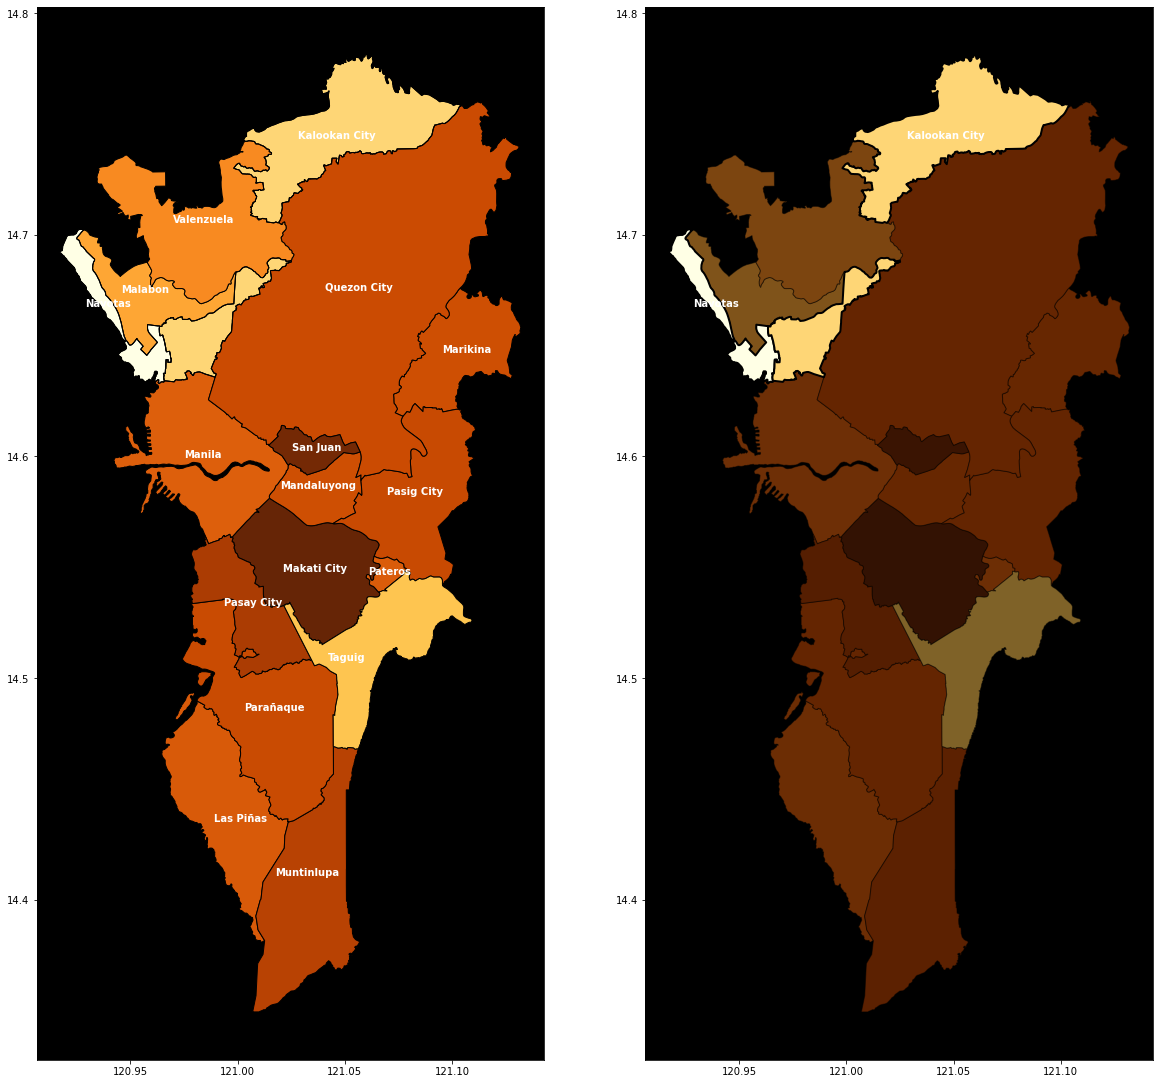

In [142]:
fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].set_facecolor('black')
df_final.plot(column='scaled_density', cmap='YlOrBr', ax=ax[0], edgecolor='black', linewidth=1, alpha=1)

df_final.loc[bottom2,:].plot(ax=ax[0], edgecolor='black', linewidth=1, facecolor='none')

for idx, row in df_final.iterrows():
    ax[0].annotate(text=idx, xy=row['coords'],
                 horizontalalignment='center', color='white', weight='bold')
    
    
ax[1].set_facecolor('black')
df_final.plot(column='scaled_density', cmap='YlOrBr', ax=ax[1], edgecolor='black', linewidth=1, alpha=0.5)

df_final.loc[bottom2,:].plot(column='scaled_density', ax=ax[1], edgecolor='black', linewidth=2, cmap='YlOrBr', vmin=0, vmax=1)

for idx, row in df_final.loc[bottom2,:].iterrows():
    ax[1].annotate(text=idx, xy=row['coords'],
                 horizontalalignment='center', color='white', weight='bold')


The plot above shows a heat map of the proportions of restaurants with respect to the population of a city. The most dense areas are Makati City and San Juan City, while the 2 least dense cities are Navotas and Kalookan. Restaurant chains would be able to leverage on this information by trying to expand to less dense areas especially Navotas and Kalookan. 